In [2]:
import os
import glob
import pickle as pk
import numpy as np
import pandas as pd
from numpy.random import randint

from tqdm.notebook import tqdm
from nilearn.image import load_img
from nilearn.masking import apply_mask, unmask
from nibabel import save
from delphi import mni_template
from delphi.utils.tools import z_transform_volume, z_transform

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.decomposition import IncrementalPCA

import matplotlib.pyplot as plt

seed = 2020

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]
#class_labels = ["footleft", "footright", "handleft", "handright", "tongue", "rest_MOTOR",
#                "body", "face", "place", "tool", "rest_WM",
#                "match", "relation", "rest_RELATIONAL",
#                "mental", "rnd", "rest_SOCIAL"]
#class_labels = ["footleft", "footright", "handleft", "handright", "tongue"]
n_classes = len(class_labels)
print(class_labels)
print("Number of classes: ", n_classes)

['footleft', 'footright', 'handleft', 'handright', 'tongue', 'loss', 'reward', 'mental', 'random', 'body', 'face', 'place', 'tool', 'match', 'relation', 'emotion', 'neut', 'story', 'math']
Number of classes:  19


In [4]:
pca_save_dir = os.path.join('./pca_models')
if not os.path.exists(pca_save_dir):
    os.mkdir(pca_save_dir)
svm_save_dir = os.path.join('./svm_models')
if not os.path.exists(svm_save_dir):
    os.mkdir(svm_save_dir)
svm_maps_dir = os.path.join('./svm_maps')
if not os.path.exists(svm_maps_dir):
    os.mkdir(svm_maps_dir)

# FUNCTIONS

In [5]:
def load_data(n, data_dir, classes, split, brain_mask=None):
    
    for i, label in tqdm(enumerate(classes), desc="class"):
        file_list = glob.glob(os.path.join(data_dir, split, label, 'sub*.nii.gz'))
        file_list = file_list[:n]
        if i == 0:
            data = apply_mask(load_img(file_list), brain_mask)
        else:
            data = np.vstack((data, apply_mask(load_img(file_list), brain_mask)))
    
    return data
            
def run_pca(data, max_components, batch_size, save_dir="./pca_models", prefix=None, seed=2020):
    """
    IncrementalPCA is helpful for datasets that require large amounts of memory.
    max_components: the number of components you want to keep
    batch_size: how many samples per batch
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_name = os.path.join(save_dir, '%s%dsamples_seed%d.pkl' % (prefix, max_components, seed))

    if os.path.exists(save_name):
        print('%s already exists. Loading instead' % save_name)
        with open(save_name, 'rb') as pickle_file:
            pca = pk.load(pickle_file)
    else:
        pca = IncrementalPCA(n_components=max_components, batch_size=batch_size)
        pca.fit(data)
        print('Saving %s for later use.' % save_name)
        with open(save_name, 'wb') as pickle_file:
            pk.dump(pca, pickle_file)
            
    return pca

def run_svm(data, Y, approach="ovr", n_classes=n_classes, prefix=None, dims=None, save_dir="./svm_models", seed=seed):
    """
    Create and train a classifier.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    if dims is None:
        dims = data.shape[1]

    save_name = os.path.join(save_dir, "%s%s_%dsubs_%ddims_seed%d.pkl" % (
    prefix, approach, data.shape[0] / n_classes, dims, seed))

    if os.path.exists(save_name):
        print('%s already exists. Loading instead' % save_name)
        with open(save_name, 'rb') as pickle_file:
            clf = pk.load(pickle_file)
    else:
        # ONE-VS-ONE
        if approach == "ovo":
            clf = OneVsOneClassifier(
                SVC(kernel="linear", probability=True, break_ties=True, random_state=seed)).fit(data[:, :dims], Y)

        # ONE-VS-REST
        elif approach == "ovr":
            clf = OneVsRestClassifier(
                SVC(kernel="linear", probability=True, break_ties=True, random_state=seed)).fit(data[:, :dims], Y)

        with open(save_name, 'wb') as pickle_file:
            pk.dump(clf, pickle_file)
            
    return clf

def save_maps(clf, data, approach, nsubs, dims, prefix=None, invert_pca=False, save_dir="./svm_maps", seed=seed, brain_mask=mni_template):
    """
    Save the weights of the classifier as .nii.gz files. These files represent the "most important" features of the classifier.
    Since the voxel values are usually quite small we first z-transform them to easier threshold the values.
    """

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_name = os.path.join(save_dir, "%s%s_%dsubs_%ddims_seed%d.nii.gz" % (prefix, approach, nsubs, dims, seed))
    if os.path.exists(save_name):
        pass
    else:
        print("saving %s" % save_name)
        n_estimators = len(clf.estimators_)
        to_save = np.zeros((n_estimators, data.shape[-1]))

        if not os.path.exists(save_name):
            for i in range(n_estimators):
                if not invert_pca:
                    to_save[i] = clf.estimators_[i].coef_
                else:
                    to_save[i] = np.dot(clf.estimators_[i].coef_, pca.components_[:dims])
        
        mu = to_save.mean(axis=1)
        mu = mu[:, np.newaxis]
        std = to_save.std(axis=1)
        std = std[:, np.newaxis]
        with np.errstate(divide='ignore'):
            z_transformed = (to_save - mu) / std
        img = unmask(z_transformed, brain_mask)
        save(img, save_name)

def predict(clf, data, Y, dims=None):
    """
    Use the trained classifier to predict the class of the input.
    """

    if dims is None:
        dims = data.shape[1]

    preds = clf.predict(data[:, :dims])
    accs = (np.sum(Y == preds) / len(Y))

    return preds, accs

In [6]:
# let's use different Ns for training and see how the classification performance changes with increasing sample sizes.
n_train_samples = [120] #[1, 10, 25, 50, 75, 120]
n_folds = 7
accs = np.zeros((n_folds, len(n_train_samples), 3))

# does smoothing affect classification performance?
data_dirs = ["../t-smoothed"] #["../v-maps/"]# ["../t-maps", "../t-smoothed"]
smoothing = [3]

In [8]:
shuffle = False

for d, data_dir in enumerate(data_dirs):
    df_train = pd.DataFrame(columns=["n_samples", "acc"])
    df_valid = pd.DataFrame(columns=["n_samples", "acc"])
    df_test = pd.DataFrame(columns=["n_samples", "acc"])
    # loop over different Ns
    for i, n_samples in enumerate(n_train_samples):

        if i == 0:
            train_data = load_data(n_samples+20, data_dir, class_labels, "train", brain_mask=mni_template)
            train_lbls = np.repeat(np.arange(n_classes), n_samples+20)
            test_data = load_data(20, data_dir, class_labels, "test", brain_mask=mni_template)
            test_lbls = np.repeat(np.arange(n_classes), 20)
        
        sss = StratifiedKFold(n_splits=n_folds)

        # train a classifier for different folds; i.e., each iteration uses a different
        # train-validation-split
        for fold, (idx_train, idx_valid) in enumerate(sss.split(train_data, train_lbls)):

            # assign a unique seed for each folds pca and svm
            this_seed = 2020 + fold

            maps = os.path.join(svm_maps_dir, f"nsubs-{n_samples:03d}")
            pcas = os.path.join(pca_save_dir, f"nsubs-{n_samples:03d}")
            svms = os.path.join(svm_save_dir, f"nsubs-{n_samples:03d}")
            prefix = f"shuffled-k-fold_ss-{smoothing[d]}mm_fold{fold:02d}_" if shuffle else f"k-fold_ss-{smoothing[d]}mm_fold{fold:02d}_"

            # select the respective data for the training and validation data/labels
            this_train_data, this_valid_data = train_data[idx_train, :], train_data[idx_valid, :]
            this_train_lbls, this_valid_lbls = train_lbls[idx_train], train_lbls[idx_valid]
            
            if shuffle:
                np.random.seed(this_seed)
                permute_idx = np.random.permutation(len(this_train_lbls))
                this_train_lbls = this_train_lbls[permute_idx]
                permute_idx = np.random.permutation(len(this_valid_lbls))
                this_valid_lbls = this_valid_lbls[permute_idx]
            
            # run a PCA on the training data
            print('Running PCA on training data...')
            max_components = min(this_train_data.shape)
            pca = run_pca(this_train_data, max_components, batch_size=max_components//10, prefix=prefix, seed=this_seed, save_dir=pcas)

            # plot explained variance per component
            #axes[0,0].plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
            #axes[0,0].set_xlabel('PC', fontsize=18);
            #axes[0,0].set_ylabel('explained variance', fontsize=16);

            # plot cumulative variance explained
            #axes[0,1].plot(np.cumsum(pca.explained_variance_ratio_))
            #axes[0,1].set_xlabel('Dimensions', fontsize=18);
            #axes[0,1].set_ylabel('Explained variance', fontsize=16);

            # transform the training and validation data data
            print('Transforming the input data...')
            train_transformed = pca.transform(this_train_data)
            valid_transformed = pca.transform(this_valid_data)
            test_transformed = pca.transform(test_data)

            # run SVM
            print('Running SVM...')
            clf = run_svm(train_transformed, this_train_lbls, approach="ovr", prefix=prefix, save_dir=svms)
            
            # performance on train set
            train_predicted, acc = predict(clf, train_transformed, this_train_lbls, train_transformed.shape[1])
            df_train = pd.concat([df_train, pd.DataFrame({"n_samples": n_samples, "acc": acc}, index=[fold])])
            
            # performance on validation set
            valid_predicted, acc = predict(clf, valid_transformed, this_valid_lbls, valid_transformed.shape[1])
            df_valid = pd.concat([df_valid, pd.DataFrame({"n_samples": n_samples, "acc": acc}, index=[fold])])
            
            # performance on test set
            test_predicted, acc = predict(clf, test_transformed, test_lbls, test_transformed.shape[1])
            df_test = pd.concat([df_test, pd.DataFrame({"n_samples": n_samples, "acc": acc}, index=[fold])])
        
            save_maps(clf, test_data, 'ovr', n_samples, test_transformed.shape[1], invert_pca=True, prefix=prefix, save_dir=maps)
            # print("%1.4f accuracy" % accs[i])
    
    df_train.to_csv(f"./stats/train_acc_ss-{smoothing[d]}mm_shuffled.csv" if shuffle else f"./stats/train_acc_ss-{smoothing[d]}mm.csv", index=False)
    df_valid.to_csv(f"./stats/valid_acc_ss-{smoothing[d]}mm_shuffled.csv" if shuffle else f"./stats/valid_acc_ss-{smoothing[d]}mm.csv", index=False)
    df_test.to_csv(f"./stats/test_acc_ss-{smoothing[d]}mm_shuffled.csv" if shuffle else f"./stats/test_acc_ss-{smoothing[d]}mm.csv", index=False)

class: 0it [00:00, ?it/s]

class: 0it [00:00, ?it/s]

Running PCA on training data...
Saving ./pca_models/nsubs-120/k-fold_ss-3mm_fold00_2280samples_seed2020.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps/nsubs-120/k-fold_ss-3mm_fold00_ovr_120subs_2280dims_seed2020.nii.gz
Running PCA on training data...
Saving ./pca_models/nsubs-120/k-fold_ss-3mm_fold01_2280samples_seed2021.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps/nsubs-120/k-fold_ss-3mm_fold01_ovr_120subs_2280dims_seed2020.nii.gz
Running PCA on training data...
Saving ./pca_models/nsubs-120/k-fold_ss-3mm_fold02_2280samples_seed2022.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps/nsubs-120/k-fold_ss-3mm_fold02_ovr_120subs_2280dims_seed2020.nii.gz
Running PCA on training data...
Saving ./pca_models/nsubs-120/k-fold_ss-3mm_fold03_2280samples_seed2023.pkl for later use.
Transforming the input data...
Running SVM...
saving ./svm_maps/nsubs-120/k-fold_ss-3mm_fold03_ovr_120subs_2280d

In [178]:
len(clf.estimators_)

19

# plot the accuracies

In [27]:
import seaborn as sns

dfs = []
smoothing = [0]#, 4]
splits = ["train", "valid", "test"]
label_order = ['', '_shuffled']

ctr = 0 
for s, lblorder in enumerate(label_order):
    
    for i, split in enumerate(splits):
        
        dfs.append(pd.read_csv(f"stats/motor_{split}_acc_ss-0mm{lblorder}.csv"))
        dfs[ctr]["split"] = split
        dfs[ctr]["order"] = "real" if s==0 else "shuffled"
        #print(split, dfs[ctr].acc.mean(), dfs[ctr].acc.std())
        ctr += 1
        
svm_motor = pd.concat(dfs)

ctr = 0 
dfs = []
for s, lblorder in enumerate(label_order):
    
    for i, split in enumerate(splits):
        
        dfs.append(pd.read_csv(f"stats/{split}_acc_ss-0mm{lblorder}.csv"))
        dfs[ctr]["split"] = split
        dfs[ctr]["order"] = "real" if s==0 else "shuffled"
        print(split, dfs[ctr].acc.mean(), dfs[ctr].acc.std())
        ctr += 1
        
svm_all = pd.concat(dfs)


train 1.0 0.0
valid 0.876315789473684 0.015716204269446418
test 0.8962406015037594 0.005856301476465142
train 1.0 0.0
valid 0.055263157894736806 0.013674085322912198
test 0.05751879699248116 0.01275058807947736


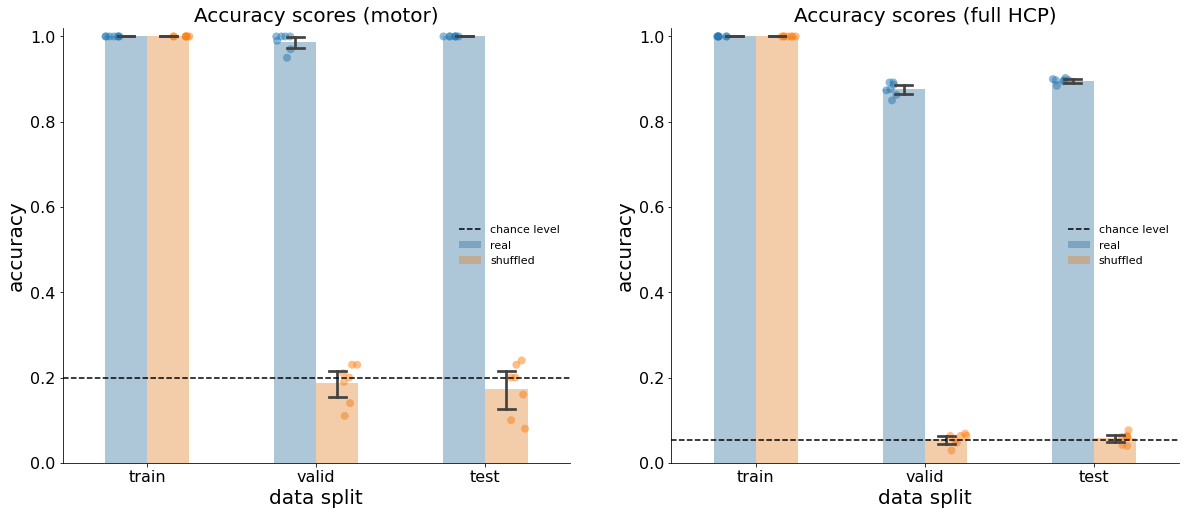

In [57]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# left plot is for the motor data only
sns.barplot(ax=axes[0], data=svm_motor, x="split", y="acc", hue="order", errorbar=("ci", 95), n_boot=5000, alpha=.4, capsize=.1, width=.5, zorder=1)
sns.stripplot(ax=axes[0], data=svm_motor, x="split", y="acc", hue="order", dodge=True, zorder=0, size=8, alpha=.5, legend=None)

axes[0].axhline(1/5, linestyle="--", color="black", label="chance level")
axes[0].set_title("Accuracy scores (motor)");

# right plot is for the entire hcp
sns.barplot(ax=axes[1], data=svm_all, x="split", y="acc", hue="order", errorbar=("ci", 95), n_boot=5000, alpha=.4, capsize=.1, width=.5, zorder=1)
sns.stripplot(ax=axes[1], data=svm_all, x="split", y="acc", hue="order", dodge=True, zorder=0, size=8, alpha=.5, legend=None)

axes[1].axhline(1/n_classes, linestyle="--", color="black", label="chance level")
axes[1].set_title("Accuracy scores (full HCP)");

for i, ax in enumerate(axes):
    ax.spines[["right", "top"]].set_visible(False)
    ax.set(ylim=[0, 1.02], ylabel="accuracy", xlabel="data split");
    ax.legend(frameon=False, fontsize=11)

plt.savefig('figures/motor-accs-across-folds-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

# ROC curves

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from delphi.utils.plots import confusion_matrix

train_lbls = np.repeat(np.arange(n_classes), 140)
test_lbls = np.repeat(np.arange(n_classes), 20)
test_data = load_data(20, "../t-maps/", class_labels, "test", brain_mask=mni_template)


label_binarizer = LabelBinarizer().fit(train_lbls)
y_onehot_test = label_binarizer.transform(test_lbls)
y_onehot_test.shape  # (n_samples, n_classes)

class: 0it [00:00, ?it/s]

(380, 19)

In [17]:
f = 1

svm_files = load_img(f"../00_svm/svm_maps/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.nii.gz")
pca_file = f"../00_svm/pca_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_2280samples_seed{2020+f}.pkl"
with open(pca_file, 'rb') as pickle_file:
    pca = pk.load(pickle_file)

svm_file = f"../00_svm/svm_models/nsubs-120/k-fold_ss-0mm_fold{f:02d}_ovr_120subs_2280dims_seed2020.pkl"
with open(svm_file, 'rb') as pickle_file:
    svm = pk.load(pickle_file)
    
test_transformed = pca.transform(test_data)
y_predicted, acc = predict(svm, test_transformed, test_lbls, test_transformed.shape[1])
y_score = svm.predict_proba(test_transformed)

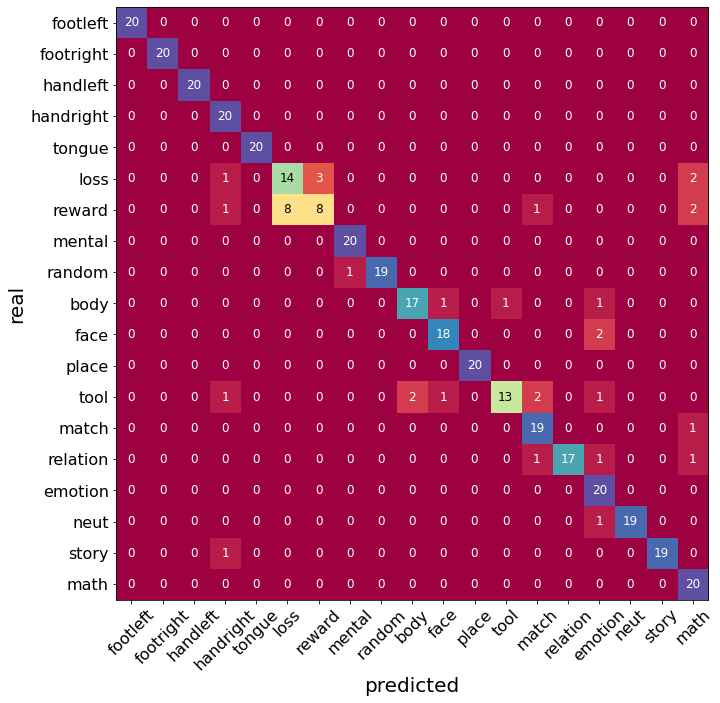

In [19]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(10, 10))

conf_mat, conf_ax = confusion_matrix(test_lbls, y_predicted, class_labels, normalize=False, ax=ax, **{"vmin": 0, "vmax": 20})
fig.tight_layout()
plt.savefig('figures/confmat-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [206]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc  = dict(), dict(), dict()
f1_test = np.zeros(n_classes)
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# F1-score
f1 = dict()
f1['micro'] = f1_score(test_lbls, y_predicted, average="micro")
f1['macro'] = f1_score(test_lbls, y_predicted, average="macro")

print(f"Micro-averaged F1: {f1['micro']}; Macro-averaged F1: {f1['macro']}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Micro-averaged F1: 0.9026315789473685; Macro-averaged F1: 0.8983602276458961


In [207]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    idc = np.where(test_lbls==i)
    f1_test[i] = f1_score(test_lbls[idc], y_predicted[idc], average="micro")
    #print(f"F1 for {class_labels[i]}: {f1_test[i]}")
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
1.00


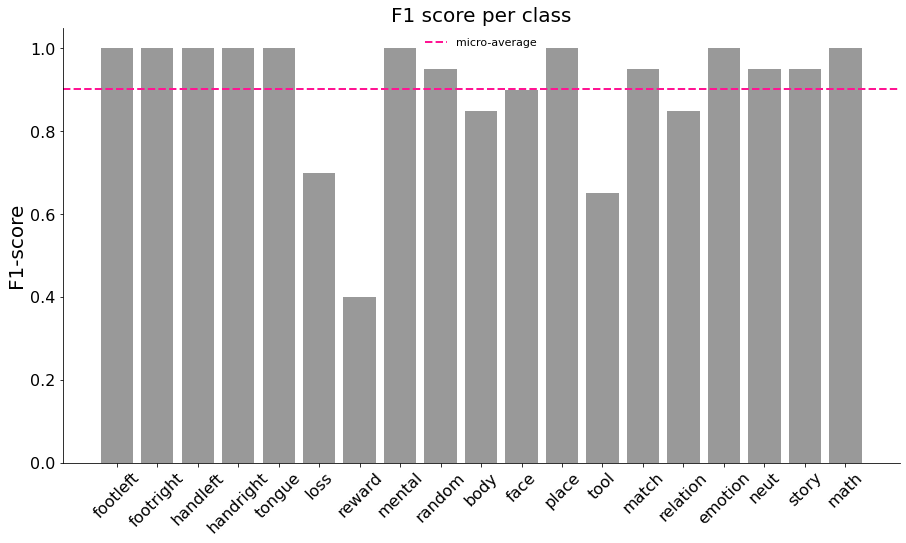

In [208]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(n_classes), f1_test, color=[.6,.6,.6])
ax.axhline(f1['micro'], linestyle="--", color="deeppink", label="micro-average", linewidth=2)
ax.set_xticks(np.arange(n_classes))
ax.set_xticklabels(class_labels, rotation=45);
ax.spines[["top", "right"]].set_visible(False);
ax.set_title("F1 score per class");
ax.set(ylabel="F1-score")
ax.legend(frameon=False, fontsize=11)

plt.savefig('figures/F1-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

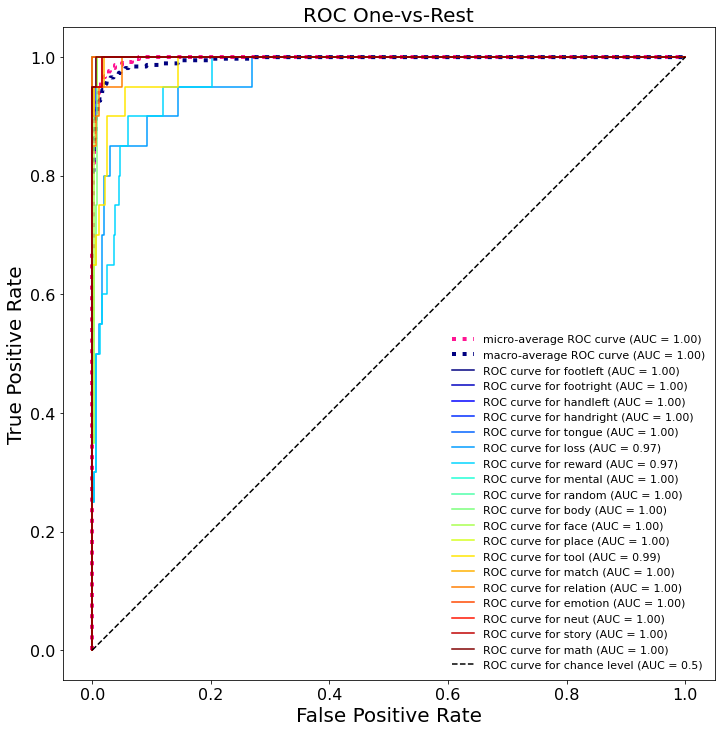

In [209]:
from itertools import cycle
from matplotlib import cm

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cm.get_cmap("jet", 19)
for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_labels[class_id]}",
        color=colors(class_id)[:3],
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC One-vs-Rest")
ax.legend(frameon=False, fontsize=11)

plt.savefig('figures/ROC-fold01-120train.pdf', facecolor=fig.get_facecolor(), transparent=True)

## Test OVO ROC

In [222]:
class_labels

['footleft',
 'footright',
 'handleft',
 'handright',
 'tongue',
 'loss',
 'reward',
 'mental',
 'random',
 'body',
 'face',
 'place',
 'tool',
 'match',
 'relation',
 'emotion',
 'neut',
 'story',
 'math']

In [229]:
from itertools import combinations

pair_list = list(combinations(np.unique([5, 6, 9, 12]), 2))
#pair_list = list(combinations(np.unique(test_lbls), 2))
print(len(pair_list))

6


Macro-averaged One-vs-One ROC AUC score:
0.93


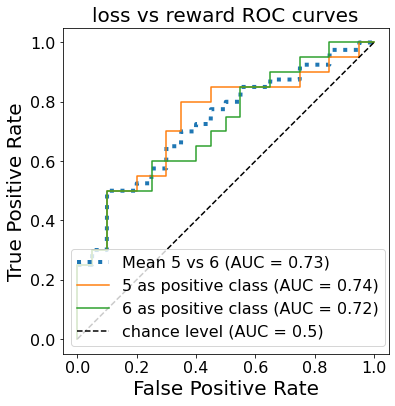

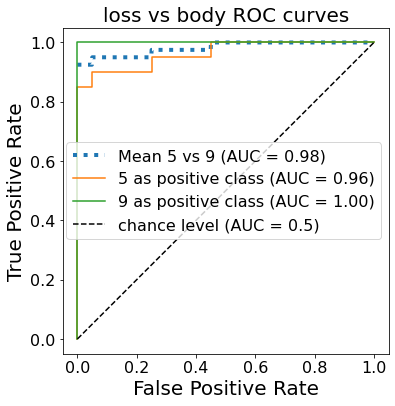

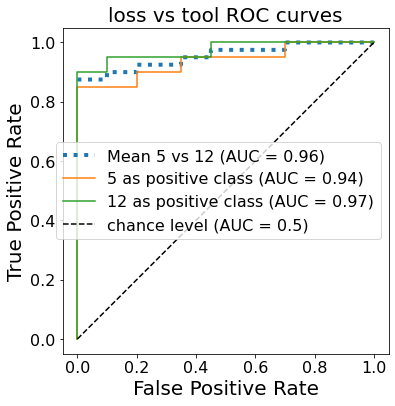

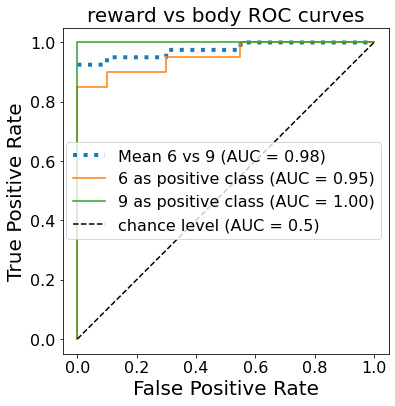

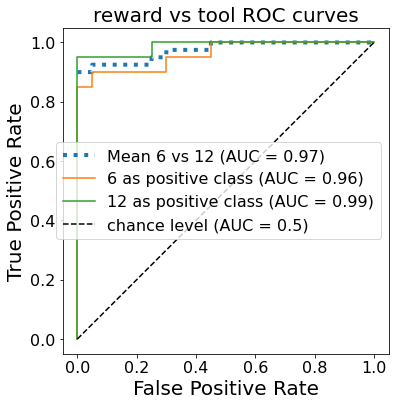

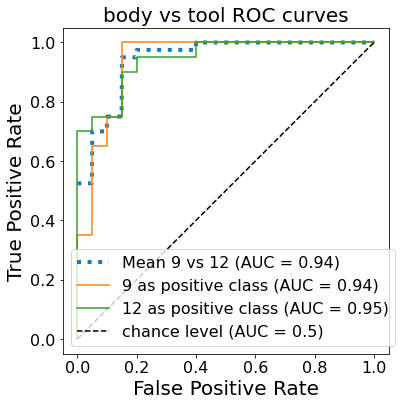

In [230]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = test_lbls == label_a
    b_mask = test_lbls == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_labels[idx_a]} vs {class_labels[idx_b]} ROC curves")
    plt.legend()
    #plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

# PRECISION RECALL CURVE

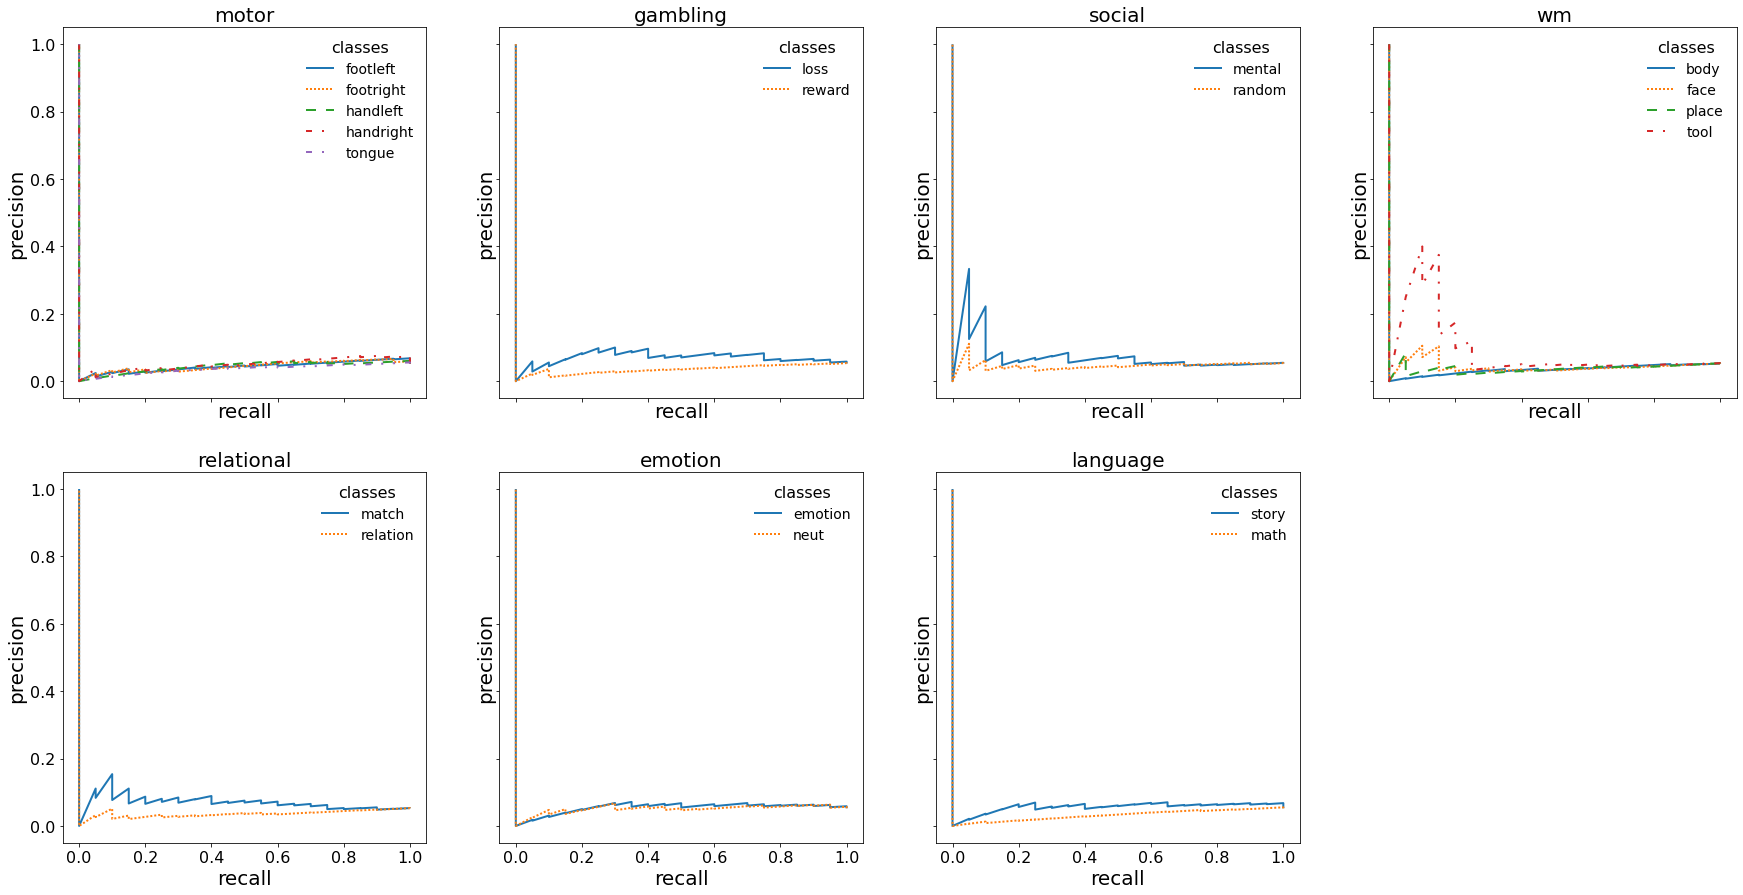

In [66]:
from sklearn.metrics import precision_recall_curve

task_names = ["motor", "gambling", "social", "wm", "relational", "emotion", "language"]
class_per_task =[["footleft", "footright", "handleft", "handright", "tongue"], 
                ["loss", "reward"], 
                ["mental", "random"], 
                ["body", "face", "place", "tool"], 
                ["match", "relation"], 
                ["emotion", "neut"], 
                ["story", "math"]]

linestyle_tuple = [
     ('solid', (0, ())),
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5)))]

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(2, 4, figsize=(30, 15), sharex=True, sharey=True)

ax = ax.flatten()
ax[-1].set_visible(False)
ctr = 0
# precision recall curve
for i, task in enumerate(class_per_task):
    #print(task)
    precision, recall = dict(), dict()
    for j, cl in enumerate(task):
        precision[j], recall[j], _ = precision_recall_curve(y_onehot_test[:, ctr],
                                                            y_score[:, ctr])
        ax[i].plot(recall[j], precision[j], lw=2, linestyle=linestyle_tuple[j][1], label='{}'.format(cl))
        ctr += 1
    
    ax[i].set_xlabel("recall")
    ax[i].set_ylabel("precision")
    ax[i].set_title(task_names[i])
    ax[i].legend(frameon=False, fontsize=14, title="classes")
    
#plt.savefig(f'figures/PR-fold01.pdf', facecolor=fig.get_facecolor(), transparent=True)

# MUTUAL INFORMATION WITH ORIGINAL DATA

In [20]:
from sklearn.feature_selection import mutual_info_regression
from nilearn.masking import apply_mask
from nilearn.image import load_img

from delphi import mni_template

class_labels = ["footleft", "footright", "handleft", "handright", "tongue", 
                "loss", "reward", 
                "mental", "random", 
                "body", "face", "place", "tool", 
                "match", "relation", 
                "emotion", "neut", 
                "story", "math"]

In [21]:
# load the group t-statistic maps
mask = load_img(mni_template)
t_group = load_img(glob.glob("../03_full_hcp/stat-maps/orig/SS3/*.nii.gz"))
t_group = apply_mask(t_group, mask)

svm_maps = load_img("svm_maps/nsubs-120/k-fold_ss-3mm_fold01_ovr_120subs_2280dims_seed2020.nii.gz")
svm_maps = apply_mask(svm_maps, mask)

In [26]:
# since we use a linear svm let's see how similar the brain maps are using correlation - vs mutual information
rho = np.zeros(19)
for i in range(19):
    a = svm_maps[i]
    b = t_group[i]

    rho[i] = np.corrcoef(a.squeeze(), b.squeeze())[0,1]
    
df_rho = pd.DataFrame({'values': rho.tolist(),'class': class_labels, 'fold': 1, 'attr_method': 'svm', 'contrast': 'grpattr-vs-grpt', 'measure': 'pearsons_r'})
df_rho
#df_rho.to_csv("stats/rho_grpattr-vs-grpt.csv", index=False)

,values,class,fold,attr_method,contrast,measure
0,0.274926,footleft,1,svm,grpattr-vs-grpt,pearsons_r
1,0.251241,footright,1,svm,grpattr-vs-grpt,pearsons_r
2,0.376249,handleft,1,svm,grpattr-vs-grpt,pearsons_r
3,0.353090,handright,1,svm,grpattr-vs-grpt,pearsons_r
4,0.429463,tongue,1,svm,grpattr-vs-grpt,pearsons_r
5,0.148261,loss,1,svm,grpattr-vs-grpt,pearsons_r
6,0.126652,reward,1,svm,grpattr-vs-grpt,pearsons_r
7,0.308502,mental,1,svm,grpattr-vs-grpt,pearsons_r
8,0.233979,random,1,svm,grpattr-vs-grpt,pearsons_r
9,0.193352,body,1,svm,grpattr-vs-grpt,pearsons_r


In [24]:
mi = np.zeros(19)
for i in range(19):
    mi[i] = mutual_info_regression(X=svm_maps[i, :].reshape(-1, 1), y=t_group[i, :], discrete_features=False, random_state=2020)

df_mi = pd.DataFrame({'values': mi.tolist(),'class': class_labels, 'fold': 0, 'attr_method': 'svm', 'contrast': 'grpattr-vs-grpt', 'measure': 'mi'})
#df_mi.to_csv("mi_grpattr-vs-grpt.csv", index=False)

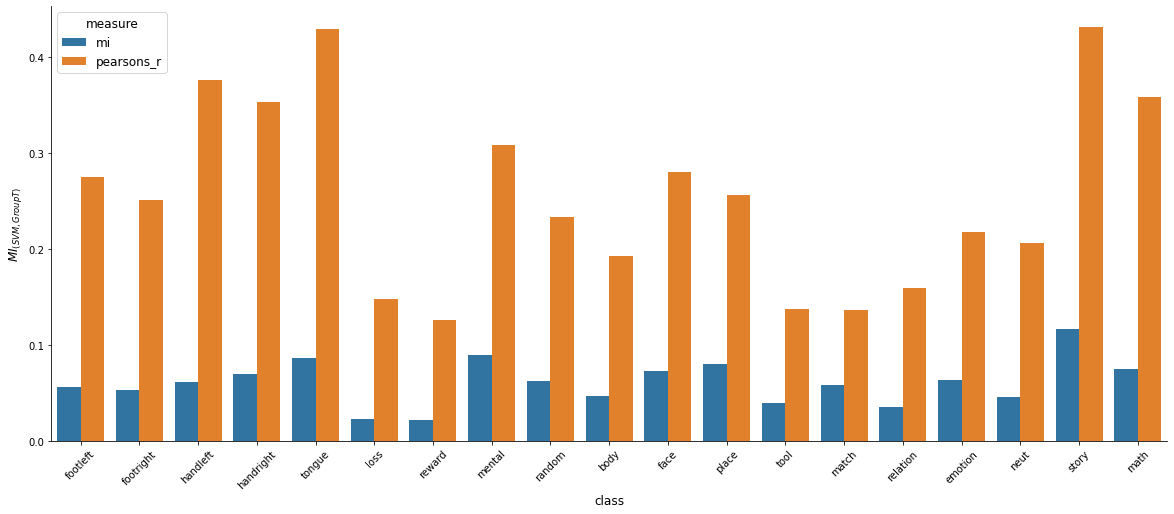

In [28]:
df_mi = df_mi.rename(columns={'mi': 'measure'})
df_rho = df_rho.rename(columns={'pearsons_r': 'measure'})

df2 = pd.concat([df_mi, df_rho])

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data=df2, x="class", y="values", hue="measure")
ax.set_xticklabels(class_labels, rotation=45);
ax.set_ylabel("$MI_{(SVM, GroupT)}$")
ax.spines[["top", "right"]].set_visible(False)
#plt.savefig(f'figures/shared-info.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [158]:
mutual_info_regression(X=svm_maps[i, :].reshape(-1, 1), y=t_group[i, :], discrete_features=False, random_state=2020)

array([0.0582951])